Setup and Dependencies

In [2]:
pip install torch nltk scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
!pip install linformer

Transformer Seq2Seq Code (Single Notebook Script)

1. Data Preparation:
- We define a small Urdu-English dataset.
- Each sentence pair is a translation of the other.
2. Vocabulary Building:
- We manually assign indices to words.
- <pad>: padding, <sos>: start of sentence, <eos>: end of sentence, <unk>: unknown token.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from sklearn.model_selection import train_test_split

nltk.download('wordnet')

# Dummy Urdu-English Dataset
data_pairs = [
    ("میں سکول جا رہا ہوں", "I am going to school"),
    ("وہ ایک ڈاکٹر ہے", "He is a doctor"),
    ("یہ ایک خوبصورت دن ہے", "It is a beautiful day"),
    ("کتاب میز پر ہے", "The book is on the table"),
    ("کیا آپ ٹھیک ہیں؟", "Are you okay?"),
    ("مجھے پانی پینا ہے", "I need to drink water"),
    ("ہم کل بازار جائیں گے", "We will go to the market tomorrow"),
    ("تم کہاں رہتے ہو؟", "Where do you live?"),
    ("میرا نام ماہ نور ہے", "My name is Mahnoor"),
    ("آپ کا شکریہ", "Thank you"),
    ("دروازہ بند کر دو", "Close the door"),
    ("مجھے مدد کی ضرورت ہے", "I need help"),
    ("کیا تم نے کھانا کھایا؟", "Did you eat food?"),
    ("میں نے فلم دیکھی", "I watched a movie"),
    ("باہر بارش ہو رہی ہے", "It is raining outside"),
    ("میں تھک گیا ہوں", "I am tired"),
    ("وہ بہت ذہین ہے", "She is very intelligent"),
    ("ہم سب دوست ہیں", "We are all friends"),
    ("تمہاری شال بہت خوبصورت ہے", "Your shawl is very beautiful"),
    ("میرے پاس ایک کتا ہے", "I have a dog")
]

# Tokenization & Vocab
def tokenize(sentence):
    return sentence.lower().split()

def build_vocab(sentences):
    vocab = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    for sentence in sentences:
        for word in tokenize(sentence):
            if word not in vocab:
                vocab[word] = len(vocab)
    return vocab

ur_sentences = [x[0] for x in data_pairs]
en_sentences = [x[1] for x in data_pairs]

ur_vocab = build_vocab(ur_sentences)
en_vocab = build_vocab(en_sentences)
inv_ur_vocab = {v: k for k, v in ur_vocab.items()}
inv_en_vocab = {v: k for k, v in en_vocab.items()}


[nltk_data] Downloading package wordnet to /root/nltk_data...


3. Encoding Sentences to Tensors
- This function converts a sentence into a fixed-length vector of word indices.
- All sentences are padded to max_len.
4. Positional Encoding
- Since transformers don’t use recurrence (like RNNs), we inject position information using sine/cosine patterns.
-Added to word embeddings.
5. Transformer Seq2Seq Model
- We create a standard encoder-decoder transformer using PyTorch’s built-in module.
- src and tgt inputs are passed with positional encodings.
- The output is passed through a linear layer to predict the next token.

Attention Mechanism
The transformer:

- Computes self-attention in encoder and decoder to find word relationships in each sentence.
- Computes cross-attention in the decoder to relate target words with source words.

In [5]:
# Convert to tensor
def encode(sentence, vocab, max_len=10):
    tokens = [vocab.get(w, vocab["<unk>"]) for w in tokenize(sentence)]
    tokens = [vocab["<sos>"]] + tokens + [vocab["<eos>"]]
    tokens += [vocab["<pad>"]] * (max_len - len(tokens))
    return torch.tensor(tokens[:max_len])

src_data = [encode(p[0], ur_vocab) for p in data_pairs]
tgt_data = [encode(p[1], en_vocab) for p in data_pairs]

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


In [6]:
# Transformer-based Seq2Seq
class TransformerTranslator(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_layers, num_layers)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)
        self.d_model = d_model

    def forward(self, src, tgt):
        src = self.pos_enc(self.src_emb(src) * math.sqrt(self.d_model))
        tgt = self.pos_enc(self.tgt_emb(tgt) * math.sqrt(self.d_model))
        src_mask = self.transformer.generate_square_subsequent_mask(src.size(1)).to(src.device)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(src.device)
        out = self.transformer(src.transpose(0, 1), tgt.transpose(0, 1), src_mask=src_mask, tgt_mask=tgt_mask)
        return self.fc_out(out.transpose(0, 1))


6. Training Loop
- For each pair:
-- Input: Urdu sentence
-- Output: English sentence (shifted for decoder input vs target)

- We use CrossEntropyLoss (ignoring <pad>) to train the network to predict the next token.
- Optimizer: Adam
7. Translation Function
-Start with <sos>, and use the model to generate one token at a time.

-Each output is fed back into the model (greedy decoding).

In [7]:
# Training Loop
def train_model(model, src_data, tgt_data, vocab, epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for src, tgt in zip(src_data, tgt_data):
            tgt_input = tgt[:-1].unsqueeze(0)
            tgt_output = tgt[1:].unsqueeze(0)

            output = model(src.unsqueeze(0), tgt_input)
            output = output.view(-1, output.shape[-1])
            tgt_output = tgt_output.view(-1)

            loss = criterion(output, tgt_output)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        if epoch % 20 == 0:
            print(f"Epoch {epoch} Loss: {total_loss:.4f}")

# Decoding
def translate(model, sentence, src_vocab, tgt_vocab, inv_tgt_vocab, max_len=10):
    model.eval()
    src_tensor = encode(sentence, src_vocab, max_len).unsqueeze(0)
    tgt_tensor = torch.tensor([[tgt_vocab["<sos>"]]], dtype=torch.long)

    for _ in range(max_len):
        out = model(src_tensor, tgt_tensor)
        next_token = out[0, -1].argmax().item()
        tgt_tensor = torch.cat([tgt_tensor, torch.tensor([[next_token]])], dim=1)
        if next_token == tgt_vocab["<eos>"]:
            break

    words = [inv_tgt_vocab.get(tok.item(), "") for tok in tgt_tensor[0][1:] if tok.item() != tgt_vocab["<eos>"]]
    return " ".join(words)



8. Evaluation Metrics
- BLEU Score: Measures n-gram precision against reference.
- METEOR Score: Also considers synonyms and stem matches (more suitable for low-resource languages).
- Both are calculated for generated vs reference sentences.



In [8]:
# Metrics
def evaluate_model(model, test_pairs):
    bleu_total, meteor_total = 0, 0
    for ur, en in test_pairs:
        pred = translate(model, ur, ur_vocab, en_vocab, inv_en_vocab)
        ref = tokenize(en)
        hyp = tokenize(pred)
        bleu = sentence_bleu([ref], hyp)
        meteor = meteor_score([ref], hyp)
        print(f"\nUrdu: {ur}\nExpected: {en}\nPredicted: {pred}\nBLEU: {bleu:.2f}, METEOR: {meteor:.2f}")
        bleu_total += bleu
        meteor_total += meteor
    print(f"\nAverage BLEU: {bleu_total/len(test_pairs):.2f}, Average METEOR: {meteor_total/len(test_pairs):.2f}")

# Initialize model
model_ur_en = TransformerTranslator(len(ur_vocab), len(en_vocab))
train_model(model_ur_en, src_data, tgt_data, en_vocab)

# Evaluate
evaluate_model(model_ur_en, data_pairs)

# Test Urdu → English
print("\nTest Urdu → English:")
for s in ["آپ کا شکریہ", "میں اسکول جا رہا ہوں"]:
    print(f"{s} => {translate(model_ur_en, s, ur_vocab, en_vocab, inv_en_vocab)}")

# Optional: English to Urdu (reverse training)
en_src = [encode(p[1], en_vocab) for p in data_pairs]
ur_tgt = [encode(p[0], ur_vocab) for p in data_pairs]
model_en_ur = TransformerTranslator(len(en_vocab), len(ur_vocab))
train_model(model_en_ur, en_src, ur_tgt, ur_vocab)

print("\nTest English → Urdu:")
for s in ["Thank you", "How are you"]:
    print(f"{s} => {translate(model_en_ur, s, en_vocab, ur_vocab, inv_ur_vocab)}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0 Loss: 81.0250
Epoch 20 Loss: 14.9595
Epoch 40 Loss: 8.4352


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



Urdu: میں سکول جا رہا ہوں
Expected: I am going to school
Predicted: i am tired
BLEU: 0.00, METEOR: 0.39

Urdu: وہ ایک ڈاکٹر ہے
Expected: He is a doctor
Predicted: we are all friends
BLEU: 0.00, METEOR: 0.00

Urdu: یہ ایک خوبصورت دن ہے
Expected: It is a beautiful day
Predicted: where do you live?
BLEU: 0.00, METEOR: 0.00

Urdu: کتاب میز پر ہے
Expected: The book is on the table
Predicted: i am tired
BLEU: 0.00, METEOR: 0.00

Urdu: کیا آپ ٹھیک ہیں؟
Expected: Are you okay?
Predicted: thank you
BLEU: 0.00, METEOR: 0.17

Urdu: مجھے پانی پینا ہے
Expected: I need to drink water
Predicted: i need help
BLEU: 0.00, METEOR: 0.39


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



Urdu: ہم کل بازار جائیں گے
Expected: We will go to the market tomorrow
Predicted: it is a beautiful day
BLEU: 0.00, METEOR: 0.00

Urdu: تم کہاں رہتے ہو؟
Expected: Where do you live?
Predicted: it is raining outside
BLEU: 0.00, METEOR: 0.00

Urdu: میرا نام ماہ نور ہے
Expected: My name is Mahnoor
Predicted: we will go to the market tomorrow
BLEU: 0.00, METEOR: 0.00

Urdu: آپ کا شکریہ
Expected: Thank you
Predicted: thank you
BLEU: 0.00, METEOR: 0.94

Urdu: دروازہ بند کر دو
Expected: Close the door
Predicted: where do you live?
BLEU: 0.00, METEOR: 0.00

Urdu: مجھے مدد کی ضرورت ہے
Expected: I need help
Predicted: i need help
BLEU: 0.00, METEOR: 0.98

Urdu: کیا تم نے کھانا کھایا؟
Expected: Did you eat food?
Predicted: thank you
BLEU: 0.00, METEOR: 0.13

Urdu: میں نے فلم دیکھی
Expected: I watched a movie
Predicted: i am tired
BLEU: 0.00, METEOR: 0.13

Urdu: باہر بارش ہو رہی ہے
Expected: It is raining outside
Predicted: it is raining outside
BLEU: 1.00, METEOR: 0.99

Urdu: میں تھک گیا ہوں
Exp

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0 Loss: 85.1578
Epoch 20 Loss: 9.0612
Epoch 40 Loss: 7.0312

Test English → Urdu:
Thank you => آپ کا شکریہ
How are you => کیا آپ ٹھیک


In [9]:
def test_custom_input(src_sentence, expected_tgt_sentence,
                      model, src_vocab, tgt_vocab, inv_tgt_vocab,
                      src_lang="Urdu", tgt_lang="English"):
    # Generate translation
    prediction = translate(model, src_sentence, src_vocab, tgt_vocab, inv_tgt_vocab)

    # Tokenize
    ref = tokenize(expected_tgt_sentence)
    hyp = tokenize(prediction)

    # Evaluation
    bleu = sentence_bleu([ref], hyp)
    meteor = meteor_score([ref], hyp)

    print(f"\n🔤 Input ({src_lang}): {src_sentence}")
    print(f"🎯 Expected ({tgt_lang}): {expected_tgt_sentence}")
    print(f"🤖 Predicted ({tgt_lang}): {prediction}")
    print(f"📊 BLEU Score: {bleu:.2f}")
    print(f"📊 METEOR Score: {meteor:.2f}")


9. Custom Input Testing
- Lets you input your own Urdu or English sentence, get the model's prediction, and evaluate it with BLEU and METEOR.
- Results are stored in a CSV file.

In [10]:
# Urdu → English
test_custom_input(
    src_sentence="میں ماہ نور ہوں",
    expected_tgt_sentence="I am Mahnoor",
    model=model_ur_en,
    src_vocab=ur_vocab,
    tgt_vocab=en_vocab,
    inv_tgt_vocab=inv_en_vocab,
    src_lang="Urdu",
    tgt_lang="English"
)


🔤 Input (Urdu): میں ماہ نور ہوں
🎯 Expected (English): I am Mahnoor
🤖 Predicted (English): i am tired
📊 BLEU Score: 0.00
📊 METEOR Score: 0.62


In [11]:
# English → Urdu
test_custom_input(
    src_sentence="It is a beautiful book",
    expected_tgt_sentence="یہ ایک خوبصورت کتاب ہے",
    model=model_en_ur,
    src_vocab=en_vocab,
    tgt_vocab=ur_vocab,
    inv_tgt_vocab=inv_ur_vocab,
    src_lang="English",
    tgt_lang="Urdu"
)



🔤 Input (English): It is a beautiful book
🎯 Expected (Urdu): یہ ایک خوبصورت کتاب ہے
🤖 Predicted (Urdu): یہ ایک خوبصورت دن ہے
📊 BLEU Score: 0.00
📊 METEOR Score: 0.75


In [12]:
pip install matplotlib pandas

10. Plotting Evaluation
- After testing several custom inputs, we visualize how good or bad the predictions are using matplotlib.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize results list
evaluation_log = []

def test_custom_input(src_sentence, expected_tgt_sentence,
                      model, src_vocab, tgt_vocab, inv_tgt_vocab,
                      src_lang="Urdu", tgt_lang="English",
                      log_file="translation_eval_log.csv"):
    # Generate translation
    prediction = translate(model, src_sentence, src_vocab, tgt_vocab, inv_tgt_vocab)

    # Tokenize
    ref = tokenize(expected_tgt_sentence)
    hyp = tokenize(prediction)

    # Evaluation
    bleu = sentence_bleu([ref], hyp)
    meteor = meteor_score([ref], hyp)

    # Display
    print(f"\n🔤 Input ({src_lang}): {src_sentence}")
    print(f"🎯 Expected ({tgt_lang}): {expected_tgt_sentence}")
    print(f"🤖 Predicted ({tgt_lang}): {prediction}")
    print(f"📊 BLEU Score: {bleu:.2f}")
    print(f"📊 METEOR Score: {meteor:.2f}")

    # Log results
    evaluation_log.append({
        "Source Language": src_lang,
        "Target Language": tgt_lang,
        "Input Sentence": src_sentence,
        "Expected Output": expected_tgt_sentence,
        "Predicted Output": prediction,
        "BLEU Score": bleu,
        "METEOR Score": meteor
    })

    # Save to CSV
    df = pd.DataFrame(evaluation_log)
    df.to_csv(log_file, index=False)

# Optional: Plot scores
def plot_evaluation_scores(log_file="translation_eval_log.csv"):
    df = pd.read_csv(log_file)
    plt.figure(figsize=(10, 5))
    plt.plot(df['BLEU Score'], label="BLEU Score", marker='o')
    plt.plot(df['METEOR Score'], label="METEOR Score", marker='x')
    plt.xticks(range(len(df)), df['Input Sentence'], rotation=45, ha='right')
    plt.ylabel("Score")
    plt.title("Translation Evaluation Metrics")
    plt.legend()
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


🔤 Input (Urdu): کیا آپ ٹھیک ہیں؟
🎯 Expected (English): Are you okay?
🤖 Predicted (English): thank you
📊 BLEU Score: 0.00
📊 METEOR Score: 0.17

🔤 Input (Urdu): ہم سب دوست ہیں
🎯 Expected (English): We are all friends
🤖 Predicted (English): we are all friends
📊 BLEU Score: 1.00
📊 METEOR Score: 0.99

🔤 Input (English): I am eating food
🎯 Expected (Urdu): میں کھانا کھا رہا ہوں
🤖 Predicted (Urdu): میں تھک گیا ہوں
📊 BLEU Score: 0.00
📊 METEOR Score: 0.20

🔤 Input (English): It is raining outside
🎯 Expected (Urdu): باہر بارش ہو رہی ہے
🤖 Predicted (Urdu): باہر بارش ہو رہی ہے
📊 BLEU Score: 1.00
📊 METEOR Score: 1.00


<ipython-input-13-2ebfaeb348d1>:54: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-2ebfaeb348d1>:54: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)


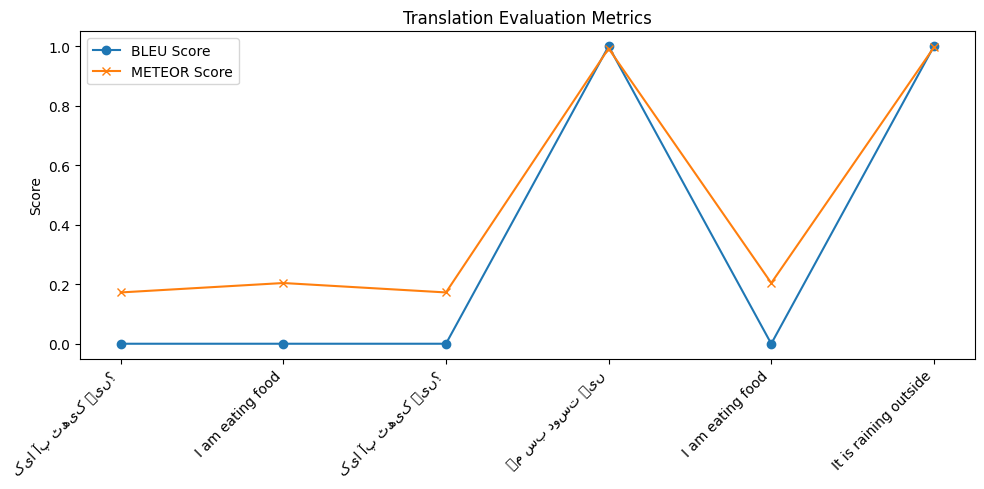

In [15]:
# Test Urdu → English
test_custom_input("کیا آپ ٹھیک ہیں؟", "Are you okay?", model_ur_en, ur_vocab, en_vocab, inv_en_vocab)
test_custom_input("ہم سب دوست ہیں", "We are all friends", model_ur_en, ur_vocab, en_vocab, inv_en_vocab)
# Test English → Urdu
test_custom_input("I am eating food", "میں کھانا کھا رہا ہوں", model_en_ur, en_vocab, ur_vocab, inv_ur_vocab,
                  src_lang="English", tgt_lang="Urdu")
test_custom_input("It is raining outside", "باہر بارش ہو رہی ہے", model_en_ur, en_vocab, ur_vocab, inv_ur_vocab,
                  src_lang="English", tgt_lang="Urdu")
# Show scores across tests
plot_evaluation_scores()